In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
starter = pd.read_csv('./datasets/train_nonulls.csv')

In [3]:
# function to create boxplots for a certain categorical variable, sorted by the median

def cat_plotter(x, kind='swarm',line=True, y='SalePrice',df=starter):
    
    order = list(pd.pivot_table(data=df, columns=x,
                    values=y, 
                    aggfunc=np.median).T.sort_values(by=y).reset_index()[x])
    
    plt.figure(figsize = (10,4))
    
    if kind == 'box':
    
        ax = sns.boxplot(x=x, y=y, data=df, order=order)
        
    elif kind == 'swarm':
        ax = sns.swarmplot(x=x, y=y, data=df, order=order,palette='ocean')
        
    elif kind == 'both':
        ax = sns.boxplot(x=x, y=y, data=df, order=order,color='white')
        sns.swarmplot(x=x, y=y, data=df, order=order, ax=ax)
        
    
    if line:    
        sns.pointplot(x=x, y=y, data=df[[x, y]].groupby(x, as_index=False).median().sort_values(y), ax=ax)
        
    
    
    ax.set_title(x,fontsize=20)
    return ax

#### Displaying all numerical attributes, by their correlation to "SalePrice"

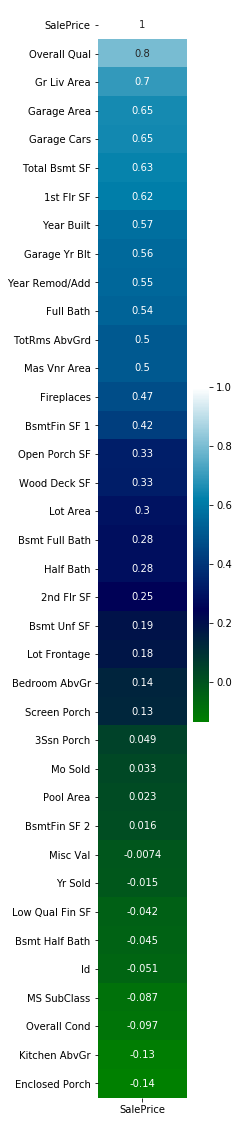

In [4]:
high_saleprice_corr = pd.DataFrame((starter.corr().abs()>.005)['SalePrice'].sort_values(ascending=False))
high_saleprice_corr_cols = high_saleprice_corr.loc[high_saleprice_corr['SalePrice'] == 1].index.tolist()

plt.figure(figsize = (2,20))

sale_corrs = starter[high_saleprice_corr_cols].corr()[['SalePrice']]

sns.heatmap(sale_corrs.sort_values('SalePrice', ascending=False),annot=True,cmap='ocean')

Apparently Overall Quality, Total SF and Gr Liv Area are the three attributes that correlate most with Sale Price. Based on the EDA plots, this isn't surprising.

It's also interesting to note that there are very few numeric features that negatively correlate with Sale Price.

There are a bunch of attributes with "quality" in the name (including 'Overall Quality', which has a very high correlation with 'SalePrice'). I am curious if it coding that column as a number or an object will lead to a more effective outcome for the model.

In [5]:
quality_attributes = [each for each in starter.columns if 'Qual' in each]
starter[quality_attributes].head()

,Overall Qual,Exter Qual,Bsmt Qual,Low Qual Fin SF,Kitchen Qual,Garage Qual
0,6,Gd,TA,0,Gd,TA
1,7,Gd,Gd,0,Gd,TA
2,5,TA,TA,0,Gd,TA
3,5,TA,Gd,0,TA,TA
4,6,TA,Fa,0,TA,TA


In [6]:
[each for each in starter.columns if 'Overall' in each]

['Overall Qual', 'Overall Cond']

Looks like most of the other 'Quality' columns are already objects, so I'll only change that one.

In [7]:
starter['Overall Qual_obj'] = starter['Overall Qual'].astype(object)
starter['Overall Cond_obj'] = starter['Overall Cond'].astype(object)

I remember there being a lot of null values for 'Pool QC'. I wonder if having a Pool would matter?

In [8]:
[each for each in starter.columns if 'Pool' in each]

['Pool Area', 'Pool QC']

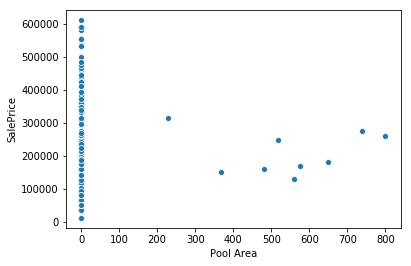

In [9]:
sns.scatterplot(starter['Pool Area'],starter['SalePrice'])

I will create a binary feature called 'Has_Pool', that will mark whether or not someone has a pool or not (I am assuming that a Pool Area of 0 means no pool).

In [10]:
starter['Has_Pool'] = starter['Pool Area'] > 0

I will do the same thing for garages

In [11]:
starter['Has_Garage'] = starter['Garage Area'] > 0

I noticed that there were a lot of different SF columns in the dataset, and a lot of them had very similar correlation to Sale Price. It could be a good idea to make a column that combines all of the 'SF' columns.

In [12]:
SF_cols = [each for each in starter.columns if 'SF' in each]
starter['Total SF'] = starter[SF_cols].sum(axis=1)

I am curious how similar Total SF and Gr Liv Area area, since Gr Liv Area seems like it serves a similar function according to the Data Description.

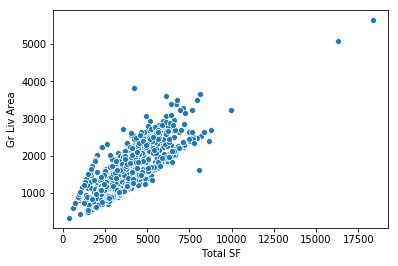

In [13]:
sns.scatterplot(starter['Total SF'], starter['Gr Liv Area'])

Since they're so co-linear, Im going to combine them into a single variable called 'Total Living Space'

In [14]:
starter['Total Living Space'] = starter['Total SF'] + starter['Gr Liv Area']

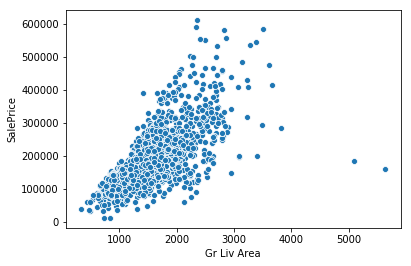

In [15]:
sns.scatterplot(starter['Gr Liv Area'], starter['SalePrice'])

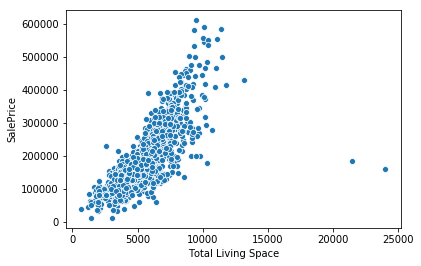

In [16]:
sns.scatterplot(starter['Total Living Space'], starter['SalePrice'])

Both Total Living Space and Gr Liv Area appear to have very similar slopes. It seems like there are two extreme outliers on this chart, both above 20000 in Total Living Space.

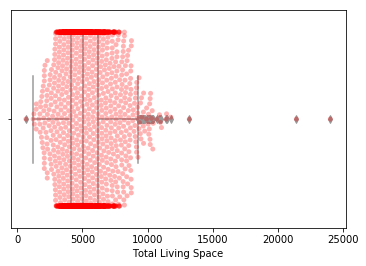

In [17]:
ax1 = sns.swarmplot(starter['Total Living Space'], color='red', alpha=.3)

ax2 = sns.boxplot(starter['Total Living Space'], color='white')

In [18]:
starter.loc[starter['Total Living Space'] > 15000]

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Mo Sold,Yr Sold,Sale Type,SalePrice,Overall Qual_obj,Overall Cond_obj,Has_Pool,Has_Garage,Total SF,Total Living Space
960,1499,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,...,1,2008,New,160000,10,5,True,True,18368.0,24010.0
1885,2181,20,RL,128.0,39290,Pave,None,IR1,Bnk,AllPub,...,10,2007,New,183850,10,5,False,True,16315.0,21410.0


I will drop the two extreme outliers, because I think they will throw off the model.

In [19]:
## Drop ID 1499 and ID 2181;

starter.drop(starter[starter['Total Living Space'] > 15000].index, inplace=True)

I am curious if designating the outliers could make a difference in the final model

In [20]:
starter['Total Living Space_morethan10k'] = starter['Total Living Space'] > 10000

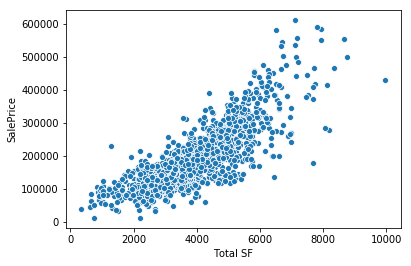

In [21]:
sns.scatterplot(starter['Total SF'], starter['SalePrice'])

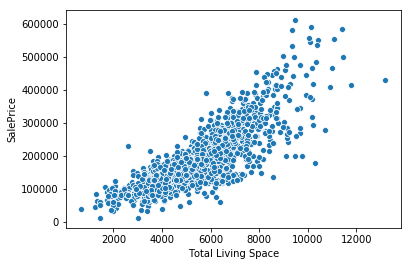

In [22]:
sns.scatterplot(starter['Total Living Space'], starter['SalePrice'])

Looks like Total Living Space is a better variable than Gr Liv Area, but might be about the same as Total SF.

I am interested in whether a variable that combined Quality and Total Living Space could be effective.

To do so, I will divide the Total Living Space by 1000, and multiple that by the Overal Quality score (numeric).

While dividing the Total Living Space by 1000 might be arbitrary in terms of model performance, I think that the smaller number will help the end user in terms of easier model interpretability.

In [23]:
starter['Qual_LivingArea'] = (starter['Total Living Space'] / 1000) * (starter['Overall Qual'])

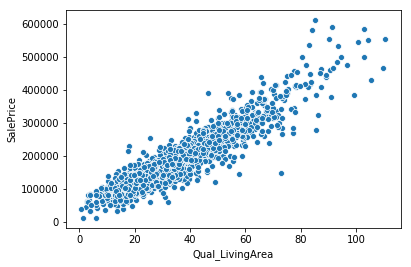

In [24]:
sns.scatterplot(starter['Qual_LivingArea'], starter['SalePrice'])

Looks like it did! I will definitely be using this variable in my model

In [25]:
starter['HasBasement'] = starter['Total Bsmt SF'] > 0

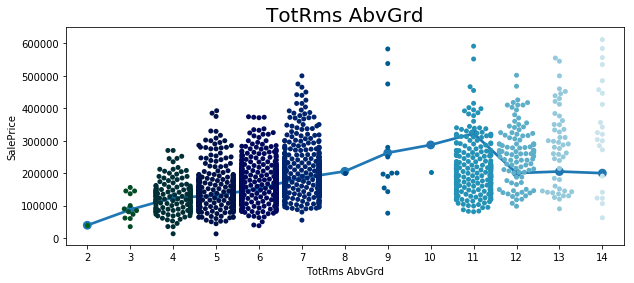

In [26]:
cat_plotter('TotRms AbvGrd')

(array([ 13., 146., 407., 597., 475., 326.,  49.,  22.,  12.,   2.]),
 array([ 2. ,  3.2,  4.4,  5.6,  6.8,  8. ,  9.2, 10.4, 11.6, 12.8, 14. ]),
 <a list of 10 Patch objects>)

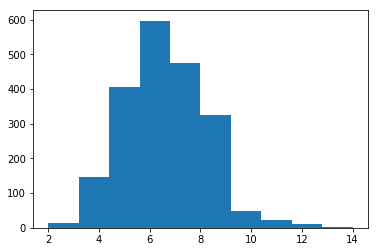

In [27]:
plt.hist(starter['TotRms AbvGrd'])

I'm going to create a variable based on whether a house has 11 or more Rooms Above Ground

In [28]:
starter['TotRms AbvGrd_9orMore'] = starter['TotRms AbvGrd'] >= 9

MS SubClass is encoced as numerical when it should be categorical

In [29]:
starter['MS SubClass'] = starter['MS SubClass'].astype(object)

In [30]:
starter['NewlyBuilt'] = starter['Year Built'] > 2005

In [31]:
starter['Built2000s'] = starter['Year Built'] > 2000

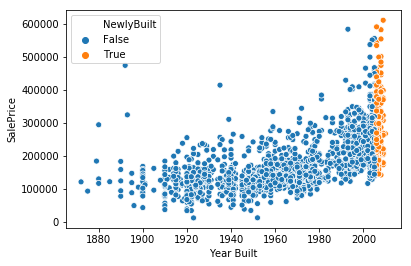

In [32]:
sns.scatterplot(starter['Year Built'], starter['SalePrice'],hue=starter['NewlyBuilt'])

In [33]:
starter['Built90s'] = (starter['Year Built'] > 1989) & (starter['Year Built'] < 2000)

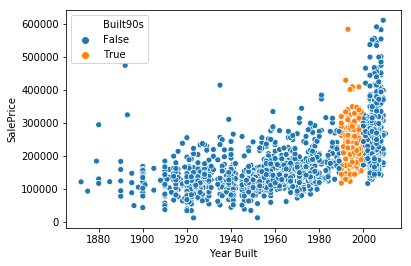

In [34]:
sns.scatterplot(starter['Year Built'], starter['SalePrice'],hue=starter['Built90s'])

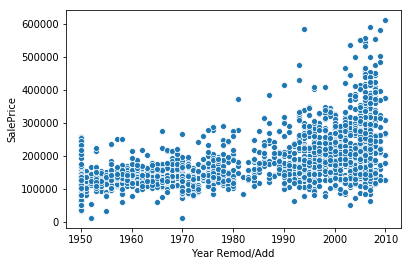

In [35]:
sns.scatterplot(starter['Year Remod/Add'], starter['SalePrice'])

In [36]:
starter['NewlyRemodeled'] = starter['Year Built'] > 2005

In [37]:
starter['Remodeled2000s'] = starter['Year Built'] > 2005

In [38]:
starter['Has Fireplace'] = starter['Fireplaces'] > 0

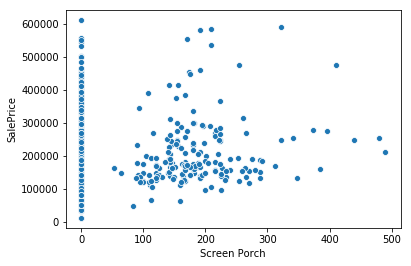

In [39]:
sns.scatterplot(starter['Screen Porch'], starter['SalePrice'])

In [40]:
starter['NoScreenPorch'] = starter['Screen Porch'] = 0

In [41]:
starter['Qual_LivingArea_high'] = (starter['Qual_LivingArea'] > 57) & (starter['Qual_LivingArea'] < 75)

In [42]:
starter['Qual_LivingArea_veryhigh'] = starter['Qual_LivingArea'] > 75

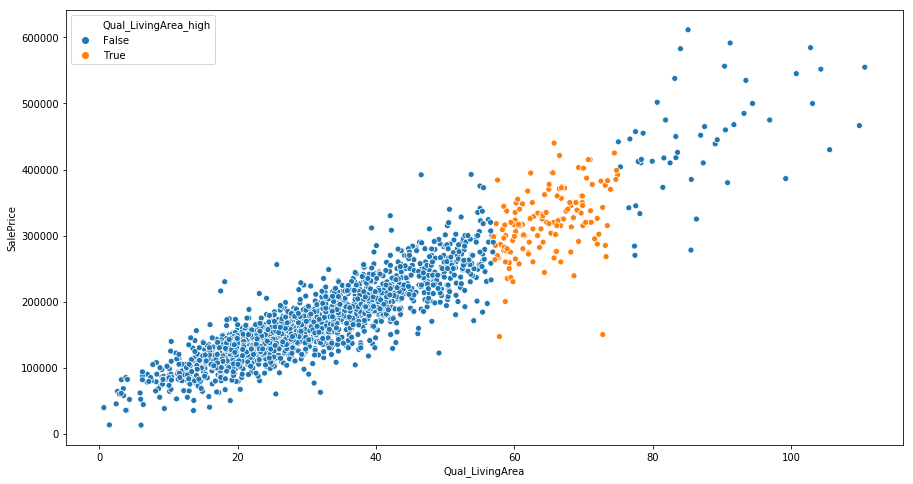

In [43]:
plt.figure(figsize = (15,8))
sns.scatterplot(starter['Qual_LivingArea'], starter['SalePrice'], hue=starter['Qual_LivingArea_high'])

In [44]:
starter.set_index('Id',inplace=True)

In [45]:
starter.to_csv('./datasets/train_wManualFeatures.csv')